# Introduction to Exploratory Data Analysis with sci-analysis
---

This notebook is a companion to the corresponding talk at PyTexas 2019: **Introduction to Exploratory Data Analysis with the sci-analysis Python Package**.

### What is sci-analysis?

sci-analysis is an open-source Python package for quickly performing statistical data analysis. It is built on top of well known and established packages in the PyData stack, such as NumPy, SciPy, Pandas and Matplotlib.

### Why sci-analysis?

sci-analysis aims to make performing Exploratory Data Analysis (EDA) easier for newcomers and experienced data scientists alike by abstracting away the specific SciPy, NumPy, and Matplotlib commands. This is accomplished by using sci-analysis’s `analyze()` function.

### Features:

* Intuitive and easy to use.
* Automatically performs the appropriate analysis based on the input data.
* Reduces the need to write boilerplate code.
* Outputs a graph, summary stats, and appropriate hypothesis test results.
* Seamlessly handles missing values.
* Input values can be python lists, tuples, dictionaries, NumPy arrays, or pandas Series.

### Analysis Types:

* Distribution of continuous, numeric data.
* Distribution of categorical data.
* Bivariate and linear regression analysis of continuous, numeric data.
* Location testing of numeric data.

## The Exercise

The best way to learn sci-analysis and what it can do is with an example. For this exercise, we'll use the NOAA GSOD data to try to answer the question **"Which city has the best weather?"** Now, the table is 16 GB and "best weather" is fairly subjective, so let's provide a few constraints.

The compared cities will be:
* Austin
* Denver
* Las Vegas
* New York
* Seattle

The years to use from the dataset are:
* 2005 - 2009

How do we define "Best Weather?", this is really subjective, but most people would agree that it's more "good weather" days than "bad weather" days. If that's the case, how can we codify "Good Weather" and "Bad Weather?" For good weather, let's try to focus on weather that affects physical comfort such as a temperature that isn't too hot or too cold, and also isn't too humid or too dry. For bad weather, let's focus on inclement weather events that are out of the ordinary.

Let's try to codify this into a formula that will score each city. The cities can then be ranked to see **"Which city has the best weather?"**

The score will be determined by:

* (Average days with temp between 60-80 F + Average days with dew point 40-60 F) / 2 - Average number of bad weather days

### Setup

Before this notebook can be run, you'll need access to the dataset, which is a Google Cloud BigQuery table. First, create a Google account if you don't already have one. Next, you can access the dataset from the Web UI [here](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=samples&t=gsod&page=table).

From the Web UI, you can briefly explore the dataset. In order to query the table from the notebook, you will need to create a new Google Cloud [Project](https://medium.com/google-cloud/how-to-create-cloud-platform-projects-using-the-google-cloud-platform-console-e6f2cb95b467).

Once a new project has been created, follow [these instructions](https://cloud.google.com/bigquery/docs/reference/libraries#client-libraries-install-python) to generate a key file that the notebook and python will use to connect to and query the table.

Next, install sci-analysis and google-cloud-bigquery by running the commands below:

In [ ]:
!pip install sci-analysis

In [ ]:
!pip install google-cloud-bigquery

After installing sci-analysis and google-cloud-bigquery, we can import biquery, pandas and the sci-analysis `analyze()` function.

In [1]:
from google.cloud import bigquery
import pandas as pd

In [2]:
%matplotlib inline
from sci_analysis import analyze

Next, the bigquery client is initialized.

In [3]:
client = bigquery.Client()

NOAA official weather stations that collect all GSOD data can be identified by their Weather-Bureau-Army-Navy (WBAN) station number. A station from each city is selected from [this list](http://www.weathergraphics.com/identifiers/master-station.dat):
* 13958 - Austin Camp Mabry
* 03017 - CO Denver/Intl
* 24233 - Seattle-Tacoma/Intl
* 94728 - New York/Central Park
* 23169 - Las Vegas/McCarran Intl

Now, let's query the table:

In [4]:
df = client.query(
  "SELECT * FROM `bigquery-public-data.samples.gsod` " \
  "WHERE wban_number IN (13958, 03017, 24233, 94728, 23169) AND year IN (2005, 2006, 2007, 2008, 2009)"
).to_dataframe()

Alternatively, if you are having trouble loading data from the Google Cloud, you can instead uncomment the code below to load the data from a csv file.

In [17]:
#df = pd.read_csv('noaa_gsod.csv')

### Exploring the Data

Referring to the cities in the dataset by their station number will get confusing fast, so lets assign city names to each corresponding WBAN station number:

In [5]:
def set_city(station):
  if station == 13958:
    city = 'Austin'
  elif station == 3017:
    city = 'Denver'
  elif station == 24233:
    city = 'Seattle'
  elif station == 94728:
    city = 'New York'
  elif station == 23169:
    city = 'Las Vegas'
  else:
    city = 'Unknown'
  return city

In [6]:
df['city'] = df['wban_number'].apply(set_city)

When working with any new dataset, it's always a good idea to check how many rows are in the dataset, what columns are available, and what their data types are.

In [7]:
len(df)

9081

In [8]:
df.columns

Index(['station_number', 'wban_number', 'year', 'month', 'day', 'mean_temp',
       'num_mean_temp_samples', 'mean_dew_point', 'num_mean_dew_point_samples',
       'mean_sealevel_pressure', 'num_mean_sealevel_pressure_samples',
       'mean_station_pressure', 'num_mean_station_pressure_samples',
       'mean_visibility', 'num_mean_visibility_samples', 'mean_wind_speed',
       'num_mean_wind_speed_samples', 'max_sustained_wind_speed',
       'max_gust_wind_speed', 'max_temperature', 'max_temperature_explicit',
       'min_temperature', 'min_temperature_explicit', 'total_precipitation',
       'snow_depth', 'fog', 'rain', 'snow', 'hail', 'thunder', 'tornado',
       'city'],
      dtype='object')

In [9]:
df.dtypes

station_number                          int64
wban_number                             int64
year                                    int64
month                                   int64
day                                     int64
mean_temp                             float64
num_mean_temp_samples                   int64
mean_dew_point                        float64
num_mean_dew_point_samples              int64
mean_sealevel_pressure                float64
num_mean_sealevel_pressure_samples    float64
mean_station_pressure                 float64
num_mean_station_pressure_samples     float64
mean_visibility                       float64
num_mean_visibility_samples             int64
mean_wind_speed                       float64
num_mean_wind_speed_samples           float64
max_sustained_wind_speed              float64
max_gust_wind_speed                   float64
max_temperature                       float64
max_temperature_explicit                 bool
min_temperature                   

Let's also check to make sure there aren't any exact duplicate rows in the dataset which could potentially skew the results. If the number of rows in the dataset doesn't change after calling `drop_duplicates()`, then our dataset is exact duplicate free.

In [10]:
len(df.drop_duplicates())

9081

### Exploring the Data with sci-analysis

Since our analysis depends on how many measurements (data points) we have for each city, it's a good idea to check to make sure the counts are roughly even for each city. If one or more cities have significantly fewer measurements compared to other cities, it will be difficult to make a fair comparison between them, which could lead us to make the wrong conclusion.

Luckily, sci-analysis makes this simple. By using the `analyze()` function and passing in the *city* column from our dataset, we can see that each of the five cities has nearly 20% of the measurements in our dataset:

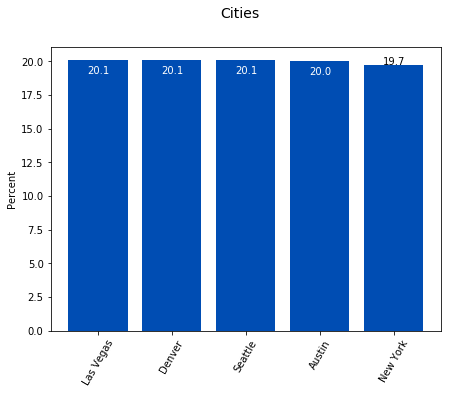



Overall Statistics
------------------

Total            =  9081
Number of Groups =  5


Statistics
----------

Rank          Frequency     Percent       Category      
--------------------------------------------------------
1             1825           20.0969      Las Vegas     
2             1824           20.0859      Denver        
3             1823           20.0749      Seattle       
4             1817           20.0088      Austin        
5             1792           19.7335      New York      


In [11]:
analyze(
    df['city'], 
    percent=True,
    vertical=False,
    title="Cities",
)

You can see that sci-analysis created a bar chart of each city by percent, as well as printed the number of measurements, number of groups, and the rank, frequency, and percent for each city.

Next, let's do the same thing for *year* and *month* to make sure the count for a particular year or month isn't significantly smaller than the others:

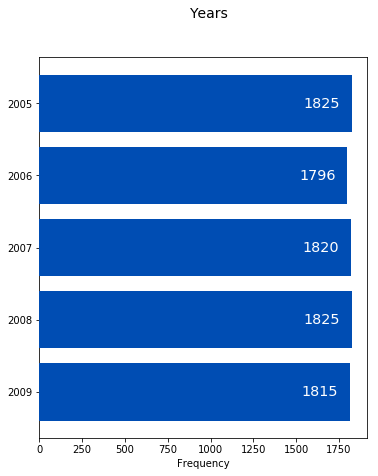



Overall Statistics
------------------

Total            =  9081
Number of Groups =  5


Statistics
----------

Rank          Frequency     Percent       Category      
--------------------------------------------------------
1             1825           20.0969      2005          
1             1825           20.0969      2008          
2             1820           20.0418      2007          
3             1815           19.9868      2009          
4             1796           19.7776      2006          


In [12]:
analyze(
    df['year'].astype(str), 
    order=['2005', '2006', '2007', '2008', '2009'],
    title="Years",
)

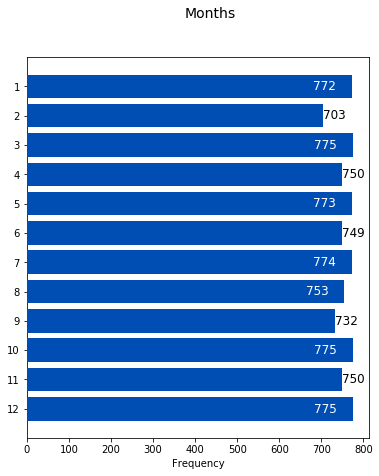



Overall Statistics
------------------

Total            =  9081
Number of Groups =  12


Statistics
----------

Rank          Frequency     Percent       Category      
--------------------------------------------------------
1             775            8.5343       10            
1             775            8.5343       12            
1             775            8.5343       3             
2             774            8.5233       7             
3             773            8.5123       5             
4             772            8.5013       1             
5             753            8.2920       8             
6             750            8.2590       11            
6             750            8.2590       4             
7             749            8.2480       6             
8             732            8.0608       9             
9             703            7.7414       2             


In [13]:
analyze(
    df['month'].astype(str), 
    order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    title='Months',
)

Since one of the criteria for determining best weather is temperature, let's examine the distribution of the temperature measurements. Our dataset contains two measurements, *mean_temp* and *max_temperature*.

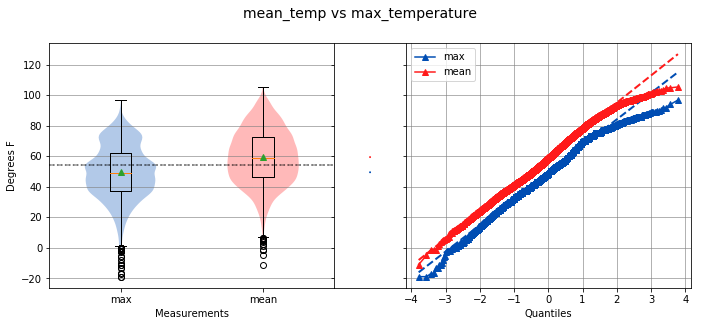



Overall Statistics
------------------

Number of Groups =  2
Total            =  18162
Grand Mean       =  54.4751
Pooled Std Dev   =  17.6159
Grand Median     =  54.0000


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
9081           49.5082       17.3755      -18.9000       48.9000       96.8000      max           
9081           59.4420       17.8530      -11.0000       59.1000       105.4000     mean          


Levene Test
-----------

alpha   =  0.0500
W value =  14.6884
p value =  0.0001

HA: Variances are not equal



Mann Whitney U Test
-------------------

alpha   =  0.0500
u value =  53642607.5000
p value =  0.0000

HA: Locations are not matched



/Users/chrismorrow/anaconda3/envs/sci_analysis_qa/lib/python3.7/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [14]:
analyze(
    {'mean': df['mean_temp'], 'max': df['max_temperature']},
    title='mean_temp vs max_temperature',
    name='Degrees F',
    categories='Measurements',
)

Weird! According to the analysis, *mean_temp* appears to have higher measurements compared to *max_temperature*. This is a valuable insight that we might have missed if we didn't compare the distributions of the two measurements with `analyze()`.

The dataset does contain a column named *num_mean_temp_samples* which might help us decide which measurement to choose.

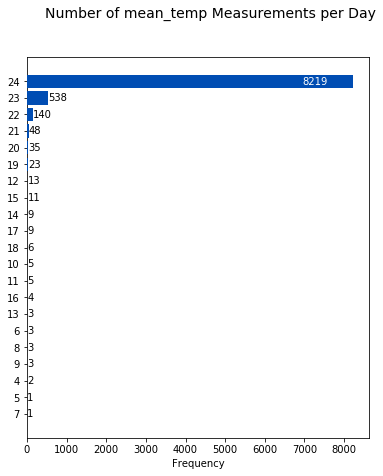



Overall Statistics
------------------

Total            =  9081
Number of Groups =  21


Statistics
----------

Rank          Frequency     Percent       Category      
--------------------------------------------------------
1             8219           90.5077      24            
2             538            5.9245       23            
3             140            1.5417       22            
4             48             0.5286       21            
5             35             0.3854       20            
6             23             0.2533       19            
7             13             0.1432       12            
8             11             0.1211       15            
9             9              0.0991       14            
9             9              0.0991       17            
10            6              0.0661       18            
11            5              0.0551       10            
11            5              0.0551       11            
12            4              0.

In [15]:
analyze(
    df['num_mean_temp_samples'].astype('str'),
    title='Number of mean_temp Measurements per Day'
)

With nearly a measurement every hour for *mean_temp* and nothing comparable for *max_temperature*, let's stick with *mean_temp*.

Let's examine the *mean_temp* distribution in more detail:

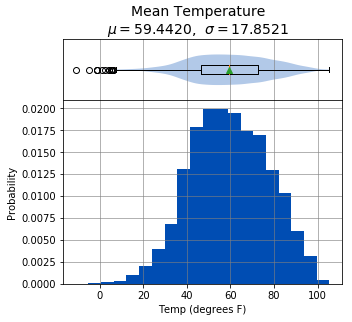



Statistics
----------

n         =  9081
Mean      =  59.4420
Std Dev   =  17.8521
Std Error =  0.1873
Skewness  = -0.0574
Kurtosis  = -0.4261
Maximum   =  105.4000
75%       =  72.7000
50%       =  59.1000
25%       =  46.4000
Minimum   = -11.0000
IQR       =  26.3000
Range     =  116.4000


Shapiro-Wilk test for normality
-------------------------------

alpha   =  0.0500
W value =  0.9947
p value =  0.0000

HA: Data is not normally distributed



In [16]:
analyze(
    df['mean_temp'], 
    bins=20,
    cdf=False,
    fit=False,
    sample=False,
    title="Mean Temperature", 
    name="Temp (degrees F)",
)

You can see that passing *mean_temp* into the `analyze()` function generates a histogram, boxplot, summary statistics, and also tests to see if the distribution comes from the normal distribution. This is a great way to get a quick look at the shape of our data. 

However, *mean_temp* here contains 5 years worth of data and spans 5 cities. It might be more useful to breakout *mean_temp* by *year* to make sure there aren't huge differences year-to-year, and by *city* since each city has it's own distinct climate.

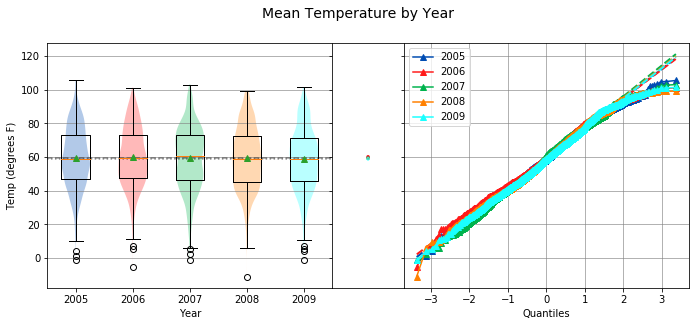



Overall Statistics
------------------

Number of Groups =  5
Total            =  9081
Grand Mean       =  59.4437
Pooled Std Dev   =  17.8514
Grand Median     =  58.8000


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
1825           59.6625       17.5526      -1.2000        58.7000       105.4000     2005          
1796           60.1960       17.2737      -5.0000        59.1500       101.1000     2006          
1820           59.2245       18.4028      -1.3000        60.5500       103.0000     2007          
1825           59.2272       18.0445      -11.0000       58.8000       99.1000      2008          
1815           58.9085       17.9550      -1.2000        58.7000       101.3000     2009          


Levene Test
-----------

alpha   =  0.0500
W value =  3.0197
p value =  0.0168

HA: Variances ar

In [17]:
analyze(
    df['mean_temp'], 
    groups=df['year'].astype(str),
    title="Mean Temperature by Year",
    name="Temp (degrees F)",
    categories="Year",
)

It looks like the median of *mean_temp* doesn't change much year-to-year which means each year can be treated as independent. Now, let's perform the same analysis for *month*:

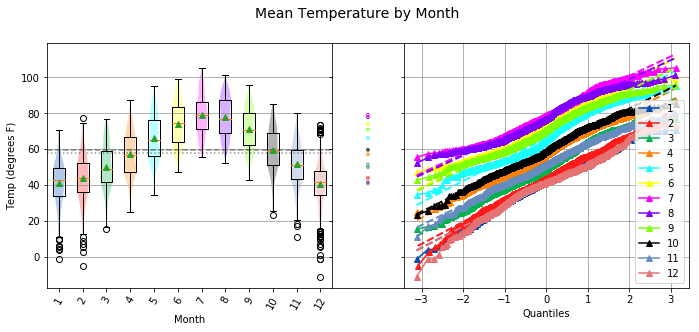



Overall Statistics
------------------

Number of Groups =  12
Total            =  9081
Grand Mean       =  59.4307
Pooled Std Dev   =  11.6826
Grand Median     =  57.9250


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
 772.0000      41.4658       12.1493      -1.3000        42.9000       70.6000       1.0000       
 703.0000      43.9575       12.2295      -5.0000        43.9000       77.6000       2.0000       
 775.0000      50.0578       12.3435       15.5000       49.2000       77.0000       3.0000       
 750.0000      57.1748       11.8260       24.9000       56.8500       87.3000       4.0000       
 773.0000      66.3135       12.1210       34.5000       65.1000       95.3000       5.0000       
 749.0000      74.0172       11.8872       47.2000       74.7000       99.0000       6.0000      

In [18]:
analyze(
    df['mean_temp'], 
    groups=df['month'],
    title="Mean Temperature by Month",
    name="Temp (degrees F)",
    categories="Month",
)

By analyzing *month* we can confirm summer months are hotter than colder months. What a relief! This might seem obvious, but it acts as a good sanity check that improves our trust in the reliability of the data.

Finally, let's analyze *mean_temp* by *city*:

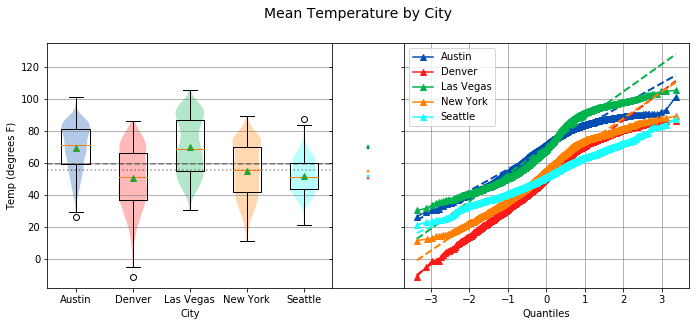



Overall Statistics
------------------

Number of Groups =  5
Total            =  9081
Grand Mean       =  59.4315
Pooled Std Dev   =  15.6006
Grand Median     =  55.4000


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
1817           69.5338       13.7406       26.5000       71.4000       101.3000     Austin        
1824           50.6471       18.1530      -11.0000       51.0000       86.3000      Denver        
1825           70.3106       17.5165       30.4000       68.5000       105.4000     Las Vegas     
1792           54.8196       16.7329       11.5000       55.4000       89.2000      New York      
1823           51.8465       10.5860       21.2000       51.2000       87.7000      Seattle       


Levene Test
-----------

alpha   =  0.0500
W value =  210.2088
p value =  0.0000

HA: Variances 

In [19]:
analyze(
    df['mean_temp'], 
    groups=df['city'], 
    title="Mean Temperature by City",
    name="Temp (degrees F)",
    categories="City",
)

There are clear differences in *mean_temp* by city which are more-or-less in line with our expectations. This is good because it means *mean_temp* will make a suitable measure for trying to answer **"Which city has the best weather?"**

Let's now repeat the same steps for *mean_dew_point* which is also part of our criteria.

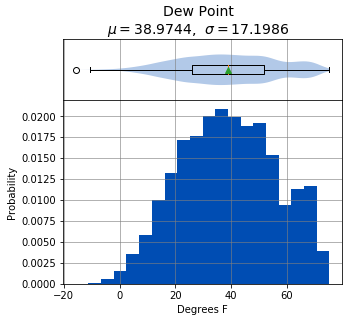



Statistics
----------

n         =  9081
Mean      =  38.9744
Std Dev   =  17.1986
Std Error =  0.1805
Skewness  = -0.0295
Kurtosis  = -0.7085
Maximum   =  75.2000
75%       =  51.7000
50%       =  38.7000
25%       =  26.0000
Minimum   = -15.7000
IQR       =  25.7000
Range     =  90.9000


Shapiro-Wilk test for normality
-------------------------------

alpha   =  0.0500
W value =  0.9874
p value =  0.0000

HA: Data is not normally distributed



In [20]:
analyze(
    df['mean_dew_point'], 
    title="Dew Point", 
    name="Degrees F",
)

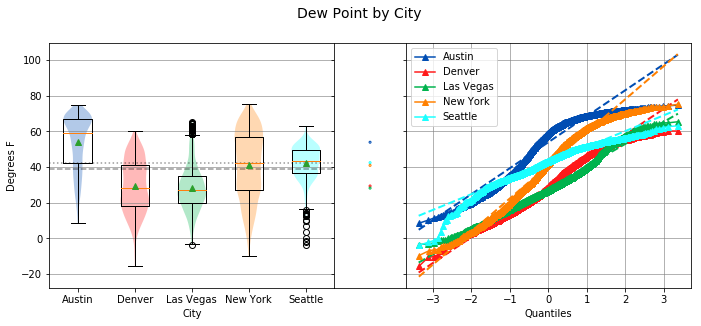



Overall Statistics
------------------

Number of Groups =  5
Total            =  9081
Grand Mean       =  38.9943
Pooled Std Dev   =  14.3617
Grand Median     =  42.3000


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
1817           53.9256       15.2793       8.5000        58.9000       74.7000      Austin        
1824           29.4137       14.5178      -15.7000       28.5500       60.2000      Denver        
1825           28.2031       12.4701      -3.4000        27.0000       65.4000      Las Vegas     
1792           40.9393       18.7991      -9.6000        42.3000       75.2000      New York      
1823           42.4900       8.9893       -3.9000        43.3000       63.1000      Seattle       


Levene Test
-----------

alpha   =  0.0500
W value =  277.4953
p value =  0.0000

HA: Variances 

In [21]:
analyze(
    df['mean_dew_point'], 
    groups=df['city'],
    title="Dew Point by City",
    name="Degrees F",
    categories="City",
)

There are clear differences in dew point between cities which means *mean_dew_point* will work well as a part of the scoring criteria.

Let's backup for a minute. What is dew point anyway and how does it relate to humidity? The dew point is defined as the temperature at which the air becomes saturated with water vapor, and the excess collects on surfaces as "dew." In fact dew forms when the dew point is greater than or equal to the temperature.

The dew point can be used to measure how "sticky" or "wet" the air feels and can make people who aren't acclimated to higher humidities feel uncomfortable when it's above 60 degrees F. On the other end, a lower dew point indicates "drier" air which can lead to skin irritation or even nose bleeds in some people.

Since there's a physical relationship between temperature and dew point, let's see how *mean_temp* correlates to *mean_dew_point*:

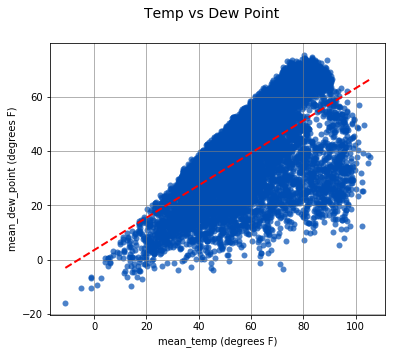



Linear Regression
-----------------

n         =  9081
Slope     =  0.5953
Intercept =  3.5884
r         =  0.6179
r^2       =  0.3818
Std Err   =  0.0079
p value   =  0.0000



Spearman Correlation Coefficient
--------------------------------

alpha   =  0.0500
r value =  0.6147
p value =  0.0000

HA: There is a significant relationship between predictor and response



In [21]:
analyze(
    df['mean_temp'], 
    df['mean_dew_point'],
    xname='mean_temp (degrees F)',
    yname='mean_dew_point (degrees F)',
    title='Temp vs Dew Point',
)

There's clearly a correlation between *mean_temp* and *mean_dew_point*, but there are quite a few points that don't seem to correlate well. Let's try grouping the correlation analysis by *city* to look for a dependency:

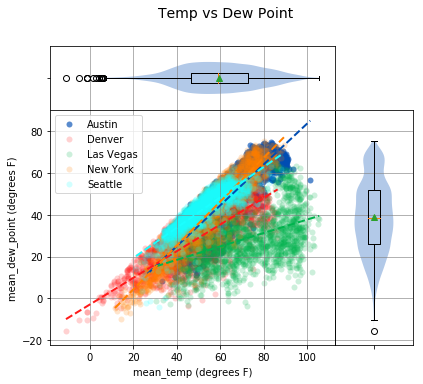



Linear Regression
-----------------

n             Slope         Intercept     r^2           Std Err       p value       Group         
--------------------------------------------------------------------------------------------------
1817           0.9786       -14.1181       0.7744        0.0124        0.0000       Austin        
1824           0.6377       -2.8848        0.6358        0.0113        0.0000       Denver        
1825           0.3217        5.5863        0.2042        0.0149        0.0000       Las Vegas     
1792           1.0508       -16.6670       0.8749        0.0094        0.0000       New York      
1823           0.7265        4.8235        0.7320        0.0103        0.0000       Seattle       


Spearman Correlation Coefficient
--------------------------------

n             r value       p value       Group         
--------------------------------------------------------
1817           0.8648        0.0000       Austin        
1824           0.7955       

In [22]:
analyze(
    df['mean_temp'], 
    df['mean_dew_point'],
    groups=df['city'],
    xname='mean_temp (degrees F)',
    yname='mean_dew_point (degrees F)',
    title='Temp vs Dew Point',
    highlight=['Austin'],
)

Grouping by *city* reveals that most of the data with a higher temperature but lower dew point is from Las Vegas. This is also reflected in the lower correlation coefficient for Las Vegas.

Denver also appears to have a slightly lower correlation coefficient compared to Austin, New York, and Seattle, so let's compare Denver and Las Vegas against New York, the city with the highest correlation:

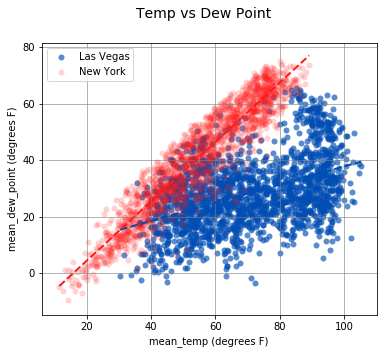



Linear Regression
-----------------

n             Slope         Intercept     r^2           Std Err       p value       Group         
--------------------------------------------------------------------------------------------------
1825           0.3217        5.5863        0.2042        0.0149        0.0000       Las Vegas     
1792           1.0508       -16.6670       0.8749        0.0094        0.0000       New York      


Spearman Correlation Coefficient
--------------------------------

n             r value       p value       Group         
--------------------------------------------------------
1825           0.4248        0.0000       Las Vegas     
1792           0.9327        0.0000       New York      


In [23]:
city = df.query("city in ['New York', 'Las Vegas']")
analyze(
    city['mean_temp'], 
    city['mean_dew_point'],
    xname='mean_temp (degrees F)',
    yname='mean_dew_point (degrees F)',
    title='Temp vs Dew Point',
    boxplot_borders=False,
    groups=city['city'],
    highlight=['Las Vegas'],
)

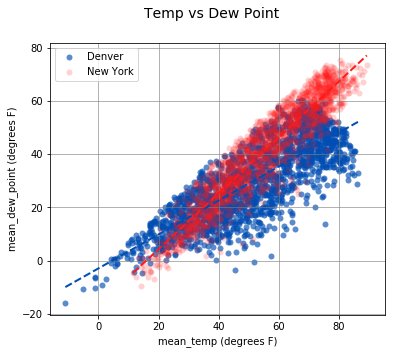



Linear Regression
-----------------

n             Slope         Intercept     r^2           Std Err       p value       Group         
--------------------------------------------------------------------------------------------------
1824           0.6377       -2.8848        0.6358        0.0113        0.0000       Denver        
1792           1.0508       -16.6670       0.8749        0.0094        0.0000       New York      


Spearman Correlation Coefficient
--------------------------------

n             r value       p value       Group         
--------------------------------------------------------
1824           0.7955        0.0000       Denver        
1792           0.9327        0.0000       New York      


In [24]:
city = df.query("city in ['New York', 'Denver']")
analyze(
    city['mean_temp'], 
    city['mean_dew_point'],
    xname='mean_temp (degrees F)',
    yname='mean_dew_point (degrees F)',
    title='Temp vs Dew Point',
    boxplot_borders=False,
    groups=city['city'],
    highlight=['Denver'],
)

The lower correlation for both Las Vegas and Denver are most likely due to the arid climate in Las Vegas and high altitude of Denver, which leads to drier air.

For assessing bad weather, there are boolean fields that indicate a type of inclement weather on a particular day.

In [25]:
df.filter(['rain', 'fog', 'snow', 'hail', 'thunder', 'tornado']).dtypes

rain       bool
fog        bool
snow       bool
hail       bool
thunder    bool
tornado    bool
dtype: object

Each of these weather events might overlap or coincide with others on any particular day, so the presence of any of these events on a particular day should be considered "bad weather".

In [26]:
def bad_weather(data):
  return True if any(data) else False

In [27]:
df['bad_weather'] = df[['rain', 'fog', 'snow', 'hail', 'thunder', 'tornado']].apply(bad_weather, axis=1)

Let's examine how many bad weather events there are relative the rest of the dataset:

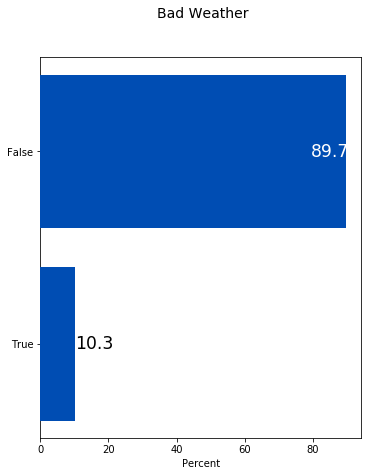



Overall Statistics
------------------

Total            =  9081
Number of Groups =  2


Statistics
----------

Rank          Frequency     Percent       Category      
--------------------------------------------------------
1             8146           89.7038      False         
2             935            10.2962      True          


In [28]:
analyze(
    df['bad_weather'].astype(str),
    percent=True,
    title='Bad Weather',
)

Finally, let's apply the rules for defining "good weather". Remember, "good weather" is defined as temperature between 60 and 80 degrees F and dew point between 40 and 60 degrees F.

In [29]:
def set_temperate(temp):
  if 60.0 <= temp <= 80.0:
    return True
  else:
    return False

In [30]:
def set_comfortable(dew_point):
  if 40.0 <= dew_point <= 60:
    return True
  else:
    return False

In [31]:
df['temperate'] = df['mean_temp'].apply(set_temperate)
df['comfortable'] = df['mean_dew_point'].apply(set_comfortable)

To determine which city has the best weather, we need to:
* Add up the number of temperate, comfortable, and bad weather days per city per year.
* Calculate the average number of temperate, comfortable, and bad weather days per city.
* Calculate the average of temperate and comfortable days, then subtract the bad weather days to determine each city's score.

In [32]:
summary = (
  df
  .filter(['year', 'city', 'temperate', 'comfortable', 'bad_weather'])
  .groupby(['city', 'year'])
  .sum()
  .groupby('city')
  .mean()
)
summary['score'] = (summary['temperate'] + summary['comfortable']) / 2 - summary['bad_weather']
summary.sort_values('score', ascending=False)

,temperate,comfortable,bad_weather,score
city,,,,
Seattle,91.2,227.2,54.8,104.4
Austin,164.4,109.6,36.6,100.4
New York,135.2,125.6,46.4,84.0
Las Vegas,113.2,53.4,4.8,78.5
Denver,114.6,101.0,44.4,63.4


So, **"Which city has the best weather?"** It's Seattle. Yep, Seattle. Despite the rain, Seattle isn't to humid or too dry.